In [1]:
%matplotlib inline

from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from matplotlib import pyplot

In [2]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
 
    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
 
    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}
 
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [3]:
def define_critic(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1))
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [4]:
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
    return model

In [5]:
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(lr=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [6]:
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	#selected_ix = trainy == 7
	X = trainX#[selected_ix]
	# expand to 3d, e.g. add channels
	#X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y


In [8]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [9]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels with 1.0 for 'fake'
	y = ones((n_samples, 1))
	return X, y

In [10]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	#filename1 = 'generated_plot_%04d.png' % (step+1)
	#pyplot.savefig(filename1)
	#pyplot.close()
	# save the generator model
	#filename2 = 'model_%04d.h5' % (step+1)
	#g_model.save(filename2)
	#print('>Saved: %s and %s' % (filename1, filename2))

In [11]:
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	#pyplot.savefig('plot_line_plot_loss.png')
	#pyplot.close()

In [12]:
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update critic model weights
			c_loss1 = c_model.train_on_batch(X_real, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update critic model weights
			c_loss2 = c_model.train_on_batch(X_fake, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(mean(c1_tmp))
		c2_hist.append(mean(c2_tmp))
		# prepare points in latent space as input for the generator
		X_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = -ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
		# evaluate the model performance every 'epoch'
		if (i+1) % bat_per_epo == 0:
			summarize_performance(i, g_model, latent_dim)
	# line plots of loss
	plot_history(c1_hist, c2_hist, g_hist)

2021-11-15 10:07:37.066106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:07:37.069964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:07:37.070312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 10:07:37.070842: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(60000, 28, 28, 1)


2021-11-15 10:07:38.174961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 10:07:38.533461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


>1, c1=-1.478, c2=0.003 g=-0.092
>2, c1=-4.770, c2=0.079 g=-1.335
>3, c1=-7.010, c2=0.133 g=-2.258
>4, c1=-8.956, c2=0.194 g=-3.463
>5, c1=-10.763, c2=0.261 g=-5.037
>6, c1=-12.308, c2=0.353 g=-6.180
>7, c1=-13.584, c2=0.438 g=-7.430
>8, c1=-15.162, c2=0.541 g=-8.908
>9, c1=-16.071, c2=0.652 g=-10.046
>10, c1=-17.524, c2=0.761 g=-11.623
>11, c1=-18.347, c2=0.858 g=-12.636
>12, c1=-19.309, c2=0.982 g=-13.853
>13, c1=-20.223, c2=1.069 g=-14.343
>14, c1=-21.000, c2=1.189 g=-15.344
>15, c1=-21.889, c2=1.277 g=-16.397
>16, c1=-22.307, c2=1.394 g=-17.092
>17, c1=-23.226, c2=1.495 g=-17.881
>18, c1=-23.445, c2=1.582 g=-18.575
>19, c1=-24.443, c2=1.620 g=-19.250
>20, c1=-24.864, c2=1.694 g=-19.272
>21, c1=-25.489, c2=1.772 g=-19.652
>22, c1=-26.106, c2=1.791 g=-20.223
>23, c1=-26.954, c2=1.782 g=-20.798
>24, c1=-27.340, c2=1.790 g=-20.993
>25, c1=-27.343, c2=1.762 g=-21.767
>26, c1=-27.899, c2=1.766 g=-22.553
>27, c1=-28.477, c2=1.909 g=-23.556
>28, c1=-28.814, c2=1.740 g=-24.670
>29, c1=-29.5

>211, c1=-166.188, c2=-161.237 g=-170.392
>212, c1=-167.048, c2=-162.187 g=-171.118
>213, c1=-166.648, c2=-162.816 g=-172.241
>214, c1=-168.060, c2=-163.843 g=-171.968
>215, c1=-169.079, c2=-164.904 g=-173.816
>216, c1=-170.445, c2=-165.681 g=-175.043
>217, c1=-171.363, c2=-166.551 g=-176.088
>218, c1=-172.002, c2=-167.496 g=-176.596
>219, c1=-172.534, c2=-168.371 g=-177.947
>220, c1=-174.516, c2=-169.268 g=-178.800
>221, c1=-175.114, c2=-170.206 g=-179.220
>222, c1=-175.540, c2=-171.079 g=-180.574
>223, c1=-176.336, c2=-172.002 g=-181.355
>224, c1=-177.185, c2=-172.786 g=-181.761
>225, c1=-178.578, c2=-173.779 g=-182.713
>226, c1=-179.433, c2=-174.501 g=-184.687
>227, c1=-180.036, c2=-175.517 g=-184.892
>228, c1=-180.914, c2=-176.487 g=-185.938
>229, c1=-181.943, c2=-177.290 g=-187.038
>230, c1=-182.909, c2=-178.249 g=-188.166
>231, c1=-183.439, c2=-179.158 g=-189.745
>232, c1=-184.828, c2=-179.978 g=-190.541
>233, c1=-185.959, c2=-180.901 g=-191.546
>234, c1=-187.439, c2=-181.845 g=-

>407, c1=-361.598, c2=-353.164 g=-354.933
>408, c1=-362.020, c2=-356.408 g=-363.156
>409, c1=-364.311, c2=-352.895 g=-361.163
>410, c1=-364.694, c2=-356.632 g=-364.708
>411, c1=-365.397, c2=-355.576 g=-360.884
>412, c1=-366.360, c2=-358.915 g=-366.382
>413, c1=-364.850, c2=-356.630 g=-354.754
>414, c1=-369.985, c2=-362.463 g=-366.709
>415, c1=-369.835, c2=-358.603 g=-364.516
>416, c1=-371.664, c2=-362.399 g=-367.380
>417, c1=-370.143, c2=-361.689 g=-365.458
>418, c1=-371.729, c2=-364.046 g=-363.291
>419, c1=-374.939, c2=-365.630 g=-372.201
>420, c1=-371.634, c2=-360.083 g=-354.137
>421, c1=-373.434, c2=-369.055 g=-367.536
>422, c1=-377.212, c2=-367.647 g=-366.662
>423, c1=-377.840, c2=-368.275 g=-372.211
>424, c1=-379.726, c2=-366.972 g=-370.133
>425, c1=-381.905, c2=-367.545 g=-367.937
>426, c1=-377.535, c2=-368.092 g=-358.016
>427, c1=-381.959, c2=-373.111 g=-369.357
>428, c1=-381.095, c2=-370.809 g=-359.252
>429, c1=-383.554, c2=-373.087 g=-367.139
>430, c1=-384.938, c2=-370.502 g=-

>606, c1=-588.132, c2=-564.000 g=560.421
>607, c1=-590.766, c2=-565.888 g=560.775
>608, c1=-591.016, c2=-568.176 g=564.472
>609, c1=-594.041, c2=-570.054 g=566.323
>610, c1=-595.221, c2=-571.988 g=567.911
>611, c1=-597.306, c2=-573.601 g=570.227
>612, c1=-599.769, c2=-575.530 g=571.805
>613, c1=-601.792, c2=-576.888 g=573.532
>614, c1=-602.544, c2=-578.863 g=575.228
>615, c1=-604.960, c2=-580.866 g=577.387
>616, c1=-605.638, c2=-581.965 g=578.990
>617, c1=-607.923, c2=-583.387 g=581.096
>618, c1=-609.567, c2=-585.297 g=583.299
>619, c1=-610.936, c2=-586.505 g=585.231
>620, c1=-613.500, c2=-588.766 g=586.854
>621, c1=-614.593, c2=-590.119 g=588.793
>622, c1=-616.085, c2=-591.541 g=590.420
>623, c1=-617.927, c2=-594.103 g=591.585
>624, c1=-619.559, c2=-595.254 g=593.386
>625, c1=-622.617, c2=-596.677 g=595.372
>626, c1=-623.416, c2=-598.801 g=597.046
>627, c1=-624.615, c2=-600.640 g=598.617
>628, c1=-627.161, c2=-601.995 g=600.782
>629, c1=-628.276, c2=-603.836 g=602.604
>630, c1=-629.83

>806, c1=-429.512, c2=305.126 g=-420.866
>807, c1=-431.856, c2=286.376 g=-420.353
>808, c1=-423.350, c2=252.966 g=-381.454
>809, c1=-424.979, c2=260.959 g=-345.223
>810, c1=-411.464, c2=258.962 g=-292.810
>811, c1=-421.848, c2=217.259 g=-254.373
>812, c1=-419.782, c2=181.522 g=-181.816
>813, c1=-406.958, c2=146.880 g=-144.898
>814, c1=-409.164, c2=87.185 g=-90.592
>815, c1=-389.297, c2=50.144 g=-34.823
>816, c1=-370.933, c2=-5.511 g=33.525
>817, c1=-380.948, c2=-36.025 g=71.608
>818, c1=-382.700, c2=-81.874 g=135.537
>819, c1=-363.588, c2=-105.059 g=192.750
>820, c1=-338.443, c2=-127.774 g=226.110
>821, c1=-334.704, c2=-158.398 g=253.949
>822, c1=-342.214, c2=-192.481 g=299.985
>823, c1=-331.262, c2=-221.366 g=331.424
>824, c1=-344.649, c2=-231.689 g=364.944
>825, c1=-306.073, c2=-254.543 g=390.070
>826, c1=-303.646, c2=-269.797 g=411.137
>827, c1=-345.294, c2=-296.578 g=441.454
>828, c1=-352.546, c2=-310.217 g=463.895
>829, c1=-343.085, c2=-311.283 g=482.075
>830, c1=-354.462, c2=-302

>1012, c1=-34.185, c2=-49.637 g=97.884
>1013, c1=-29.069, c2=-54.606 g=103.884
>1014, c1=-24.078, c2=-51.603 g=105.753
>1015, c1=-31.370, c2=-43.843 g=106.069
>1016, c1=-39.370, c2=-41.787 g=94.590
>1017, c1=-35.023, c2=-35.593 g=90.934
>1018, c1=-29.487, c2=-55.760 g=103.184
>1019, c1=-33.033, c2=-42.604 g=93.033
>1020, c1=-46.109, c2=-45.912 g=100.797
>1021, c1=-31.419, c2=-48.992 g=99.806
>1022, c1=-36.113, c2=-49.201 g=108.616
>1023, c1=-37.063, c2=-51.320 g=114.103
>1024, c1=-30.071, c2=-44.655 g=96.111
>1025, c1=-32.915, c2=-56.445 g=92.850
>1026, c1=-32.731, c2=-46.859 g=88.475
>1027, c1=-31.828, c2=-48.298 g=98.616
>1028, c1=-38.420, c2=-48.397 g=114.438
>1029, c1=-38.426, c2=-54.077 g=103.770
>1030, c1=-33.020, c2=-52.734 g=92.114
>1031, c1=-15.366, c2=-51.053 g=101.593
>1032, c1=-33.211, c2=-57.192 g=101.780
>1033, c1=-20.644, c2=-56.533 g=108.834
>1034, c1=-17.430, c2=-48.637 g=93.474
>1035, c1=-24.677, c2=-48.858 g=101.969
>1036, c1=-20.104, c2=-56.009 g=94.999
>1037, c1=-2

>1218, c1=-15.738, c2=-86.264 g=132.244
>1219, c1=-27.333, c2=-69.629 g=120.659
>1220, c1=-15.198, c2=-79.579 g=118.706
>1221, c1=-22.253, c2=-88.839 g=133.025
>1222, c1=-25.348, c2=-74.791 g=128.143
>1223, c1=-15.688, c2=-79.860 g=127.183
>1224, c1=-19.917, c2=-82.251 g=119.673
>1225, c1=-13.271, c2=-70.312 g=131.277
>1226, c1=-25.904, c2=-71.909 g=124.721
>1227, c1=-13.994, c2=-71.765 g=132.802
>1228, c1=-28.688, c2=-76.807 g=121.397
>1229, c1=-24.892, c2=-68.462 g=123.089
>1230, c1=-18.872, c2=-79.488 g=124.967
>1231, c1=-23.467, c2=-75.019 g=125.468
>1232, c1=-23.552, c2=-79.474 g=109.512
>1233, c1=-21.640, c2=-77.170 g=135.362
>1234, c1=-17.510, c2=-92.558 g=125.087
>1235, c1=-16.549, c2=-72.570 g=122.168
>1236, c1=-34.276, c2=-77.166 g=126.261
>1237, c1=-20.855, c2=-82.620 g=108.234
>1238, c1=-36.860, c2=-68.927 g=113.030
>1239, c1=-24.596, c2=-81.642 g=121.095
>1240, c1=-21.406, c2=-81.545 g=125.137
>1241, c1=-23.210, c2=-74.735 g=120.675
>1242, c1=-25.861, c2=-78.314 g=105.539


>1427, c1=-24.026, c2=-66.106 g=81.884
>1428, c1=-22.372, c2=-65.306 g=100.014
>1429, c1=-9.903, c2=-63.969 g=102.974
>1430, c1=-6.318, c2=-76.816 g=100.326
>1431, c1=-40.531, c2=-99.558 g=108.209
>1432, c1=-19.971, c2=-57.330 g=85.111
>1433, c1=-42.240, c2=-54.692 g=97.250
>1434, c1=-15.610, c2=-56.699 g=107.545
>1435, c1=-33.481, c2=-55.830 g=103.851
>1436, c1=-31.933, c2=-60.808 g=110.179
>1437, c1=-28.112, c2=-62.819 g=100.739
>1438, c1=-31.247, c2=-58.177 g=112.434
>1439, c1=-32.337, c2=-71.824 g=102.899
>1440, c1=-20.846, c2=-77.950 g=102.011
>1441, c1=-23.467, c2=-72.292 g=114.626
>1442, c1=-31.332, c2=-66.036 g=110.537
>1443, c1=-19.164, c2=-76.763 g=109.365
>1444, c1=-38.122, c2=-84.359 g=105.567
>1445, c1=-21.724, c2=-87.575 g=103.597
>1446, c1=-20.122, c2=-66.486 g=102.153
>1447, c1=-28.612, c2=-72.155 g=96.409
>1448, c1=-32.549, c2=-62.140 g=107.247
>1449, c1=-14.178, c2=-68.431 g=103.448
>1450, c1=-39.098, c2=-72.514 g=110.773
>1451, c1=-22.213, c2=-73.469 g=114.011
>1452,

>1635, c1=-63.706, c2=-32.738 g=68.169
>1636, c1=-53.803, c2=-40.313 g=66.686
>1637, c1=-53.721, c2=-34.013 g=79.246
>1638, c1=-59.830, c2=-31.569 g=77.130
>1639, c1=-58.865, c2=-33.199 g=81.063
>1640, c1=-62.845, c2=-28.176 g=80.024
>1641, c1=-54.776, c2=-34.142 g=68.216
>1642, c1=-50.721, c2=-30.597 g=74.013
>1643, c1=-53.527, c2=-31.017 g=77.427
>1644, c1=-60.408, c2=-28.724 g=75.268
>1645, c1=-61.535, c2=-30.271 g=67.761
>1646, c1=-51.889, c2=-32.220 g=73.448
>1647, c1=-62.846, c2=-35.461 g=78.102
>1648, c1=-62.841, c2=-35.291 g=84.247
>1649, c1=-57.573, c2=-34.673 g=85.031
>1650, c1=-58.269, c2=-30.677 g=74.679
>1651, c1=-56.195, c2=-41.215 g=76.856
>1652, c1=-53.740, c2=-30.217 g=74.249
>1653, c1=-46.213, c2=-34.393 g=66.677
>1654, c1=-52.144, c2=-28.469 g=79.574
>1655, c1=-47.231, c2=-36.418 g=86.465
>1656, c1=-54.808, c2=-24.841 g=71.410
>1657, c1=-61.145, c2=-34.722 g=64.223
>1658, c1=-53.691, c2=-32.115 g=80.664
>1659, c1=-54.817, c2=-31.218 g=63.069
>1660, c1=-65.159, c2=-21

>1846, c1=-81.892, c2=-6.586 g=48.262
>1847, c1=-84.834, c2=-6.054 g=52.984
>1848, c1=-86.953, c2=-11.080 g=46.490
>1849, c1=-96.066, c2=-3.817 g=47.665
>1850, c1=-80.196, c2=-3.519 g=47.564
>1851, c1=-80.148, c2=-6.441 g=45.955
>1852, c1=-61.728, c2=-13.324 g=47.012
>1853, c1=-86.881, c2=-8.712 g=48.664
>1854, c1=-85.654, c2=-1.292 g=46.128
>1855, c1=-77.583, c2=-2.372 g=54.050
>1856, c1=-83.885, c2=-3.551 g=38.954
>1857, c1=-87.571, c2=-4.075 g=46.582
>1858, c1=-88.722, c2=6.327 g=46.726
>1859, c1=-87.922, c2=-4.886 g=53.820
>1860, c1=-91.679, c2=4.756 g=49.213
>1861, c1=-80.235, c2=-1.832 g=40.285
>1862, c1=-77.402, c2=0.670 g=47.221
>1863, c1=-97.265, c2=8.002 g=44.633
>1864, c1=-76.950, c2=-1.802 g=41.665
>1865, c1=-82.454, c2=-8.619 g=40.513
>1866, c1=-74.675, c2=-3.413 g=35.312
>1867, c1=-93.493, c2=-4.279 g=32.467
>1868, c1=-88.690, c2=-0.488 g=27.667
>1869, c1=-98.603, c2=-3.814 g=34.521
>1870, c1=-76.527, c2=-10.926 g=58.355
>1871, c1=-92.430, c2=-8.780 g=42.543
>1872, c1=-97

>2061, c1=-128.280, c2=48.683 g=-5.895
>2062, c1=-129.690, c2=47.665 g=-4.109
>2063, c1=-119.454, c2=38.697 g=-4.580
>2064, c1=-124.524, c2=40.560 g=7.939
>2065, c1=-133.839, c2=34.212 g=9.442
>2066, c1=-122.799, c2=38.370 g=16.127
>2067, c1=-126.968, c2=36.971 g=4.741
>2068, c1=-126.468, c2=32.178 g=3.903
>2069, c1=-128.589, c2=40.191 g=4.907
>2070, c1=-115.387, c2=39.673 g=14.066
>2071, c1=-126.658, c2=34.312 g=0.895
>2072, c1=-115.711, c2=32.500 g=7.732
>2073, c1=-116.965, c2=32.290 g=-3.133
>2074, c1=-126.381, c2=33.968 g=-2.760
>2075, c1=-130.908, c2=34.708 g=-0.774
>2076, c1=-120.713, c2=38.390 g=5.455
>2077, c1=-123.058, c2=34.999 g=12.343
>2078, c1=-124.485, c2=33.158 g=21.078
>2079, c1=-114.103, c2=31.025 g=24.182
>2080, c1=-123.283, c2=35.241 g=7.478
>2081, c1=-123.614, c2=34.709 g=0.299
>2082, c1=-117.605, c2=38.523 g=-3.126
>2083, c1=-115.393, c2=31.128 g=9.340
>2084, c1=-128.534, c2=34.576 g=5.695
>2085, c1=-119.255, c2=27.956 g=10.103


2021-11-15 10:15:41.385861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2086, c1=-116.837, c2=36.201 g=5.673
>2087, c1=-126.960, c2=34.538 g=6.521
>2088, c1=-123.302, c2=31.183 g=12.711
>2089, c1=-113.755, c2=26.462 g=9.875
>2090, c1=-120.612, c2=29.911 g=13.768
>2091, c1=-110.734, c2=36.440 g=5.329
>2092, c1=-125.153, c2=29.410 g=7.846
>2093, c1=-129.216, c2=33.890 g=9.331
>2094, c1=-131.397, c2=41.223 g=-3.294
>2095, c1=-124.539, c2=47.072 g=4.624
>2096, c1=-115.747, c2=33.886 g=3.203
>2097, c1=-125.448, c2=38.672 g=6.564
>2098, c1=-135.905, c2=32.980 g=11.338
>2099, c1=-108.266, c2=36.416 g=-10.706
>2100, c1=-125.423, c2=33.959 g=16.596
>2101, c1=-114.531, c2=23.266 g=17.590
>2102, c1=-125.212, c2=38.157 g=-0.970
>2103, c1=-131.477, c2=37.540 g=19.126
>2104, c1=-116.966, c2=37.591 g=3.397
>2105, c1=-115.659, c2=34.903 g=2.113
>2106, c1=-119.545, c2=25.296 g=5.379
>2107, c1=-126.333, c2=29.038 g=12.377
>2108, c1=-129.794, c2=28.251 g=10.739
>2109, c1=-128.263, c2=32.243 g=4.086
>2110, c1=-115.023, c2=34.190 g=12.770
>2111, c1=-115.648, c2=27.305 g=21.14

>2298, c1=-141.255, c2=60.279 g=-10.528
>2299, c1=-140.521, c2=56.201 g=-3.018
>2300, c1=-140.784, c2=58.760 g=-17.357
>2301, c1=-149.397, c2=54.457 g=-10.514
>2302, c1=-144.769, c2=57.161 g=-14.880
>2303, c1=-150.571, c2=60.597 g=-14.500
>2304, c1=-148.297, c2=64.294 g=-8.037
>2305, c1=-144.780, c2=63.698 g=-12.067
>2306, c1=-139.952, c2=54.209 g=-5.594
>2307, c1=-141.433, c2=57.187 g=-8.846
>2308, c1=-140.551, c2=50.541 g=12.086
>2309, c1=-127.330, c2=49.255 g=0.727
>2310, c1=-146.639, c2=54.043 g=-10.543
>2311, c1=-126.151, c2=49.531 g=-4.980
>2312, c1=-139.414, c2=57.498 g=-21.256
>2313, c1=-145.294, c2=49.893 g=-20.981
>2314, c1=-131.308, c2=55.659 g=-20.331
>2315, c1=-135.143, c2=49.983 g=-11.643
>2316, c1=-135.843, c2=52.998 g=-0.704
>2317, c1=-131.070, c2=53.580 g=16.139
>2318, c1=-132.891, c2=46.766 g=0.676
>2319, c1=-132.811, c2=56.621 g=-6.193
>2320, c1=-142.902, c2=56.334 g=-19.966
>2321, c1=-146.717, c2=59.237 g=-18.003
>2322, c1=-144.970, c2=55.938 g=-10.282
>2323, c1=-14

>2506, c1=-135.068, c2=56.420 g=-22.804
>2507, c1=-139.447, c2=53.829 g=-1.247
>2508, c1=-125.106, c2=58.848 g=5.413
>2509, c1=-123.985, c2=57.467 g=-33.096
>2510, c1=-140.365, c2=66.776 g=-14.552
>2511, c1=-134.298, c2=67.611 g=-21.239
>2512, c1=-132.161, c2=63.114 g=-6.989
>2513, c1=-126.684, c2=60.407 g=6.877
>2514, c1=-124.423, c2=60.020 g=-15.821
>2515, c1=-136.737, c2=63.966 g=-2.872
>2516, c1=-133.637, c2=58.129 g=-14.874
>2517, c1=-130.674, c2=58.715 g=-19.187
>2518, c1=-131.469, c2=57.879 g=-12.084
>2519, c1=-126.263, c2=53.199 g=-5.804
>2520, c1=-125.159, c2=54.577 g=-7.520
>2521, c1=-131.451, c2=59.643 g=3.077
>2522, c1=-126.392, c2=56.021 g=-13.945
>2523, c1=-144.242, c2=56.273 g=2.851
>2524, c1=-128.329, c2=65.648 g=-5.740
>2525, c1=-121.494, c2=56.373 g=-17.128
>2526, c1=-131.928, c2=56.655 g=-14.478
>2527, c1=-132.458, c2=52.236 g=-22.178
>2528, c1=-129.618, c2=57.636 g=-14.601
>2529, c1=-136.095, c2=57.201 g=-2.056
>2530, c1=-124.607, c2=56.223 g=-17.657
>2531, c1=-123.

>2713, c1=-129.814, c2=68.682 g=-17.087
>2714, c1=-145.861, c2=67.630 g=-22.572
>2715, c1=-141.016, c2=67.343 g=-26.405
>2716, c1=-133.225, c2=74.068 g=-25.557
>2717, c1=-132.301, c2=60.077 g=-23.267
>2718, c1=-134.976, c2=59.219 g=-31.304
>2719, c1=-132.692, c2=65.393 g=-31.242
>2720, c1=-145.720, c2=77.488 g=-27.202
>2721, c1=-143.397, c2=75.981 g=-20.932
>2722, c1=-134.431, c2=72.840 g=-24.982
>2723, c1=-135.935, c2=69.929 g=-20.386
>2724, c1=-149.131, c2=76.029 g=-30.299
>2725, c1=-150.950, c2=68.482 g=-0.265
>2726, c1=-125.018, c2=62.555 g=-9.143
>2727, c1=-143.785, c2=71.250 g=-18.740
>2728, c1=-136.963, c2=67.383 g=-15.540
>2729, c1=-130.846, c2=64.978 g=-20.740
>2730, c1=-138.955, c2=74.707 g=-22.971
>2731, c1=-132.021, c2=67.411 g=-26.269
>2732, c1=-147.933, c2=58.545 g=-5.706
>2733, c1=-133.644, c2=72.428 g=-24.209
>2734, c1=-139.237, c2=65.058 g=-22.304
>2735, c1=-136.299, c2=64.368 g=-15.467
>2736, c1=-140.403, c2=68.550 g=-33.296
>2737, c1=-144.076, c2=62.273 g=-26.663
>27

>2919, c1=-101.160, c2=51.569 g=-21.270
>2920, c1=-110.064, c2=60.105 g=-18.551
>2921, c1=-117.500, c2=62.777 g=1.837
>2922, c1=-117.413, c2=55.869 g=-19.530
>2923, c1=-122.897, c2=62.351 g=-22.077
>2924, c1=-114.025, c2=64.088 g=-15.880
>2925, c1=-124.139, c2=53.122 g=-19.205
>2926, c1=-117.913, c2=60.026 g=-7.393
>2927, c1=-115.010, c2=57.260 g=-19.125
>2928, c1=-122.660, c2=59.689 g=-25.111
>2929, c1=-131.316, c2=66.338 g=-4.799
>2930, c1=-116.871, c2=66.562 g=-13.525
>2931, c1=-129.303, c2=63.782 g=-25.291
>2932, c1=-131.707, c2=64.902 g=-22.715
>2933, c1=-108.708, c2=63.587 g=-15.068
>2934, c1=-112.870, c2=62.492 g=-16.771
>2935, c1=-123.444, c2=62.489 g=-18.889
>2936, c1=-116.690, c2=57.303 g=-15.077
>2937, c1=-114.648, c2=60.805 g=-21.080
>2938, c1=-117.854, c2=69.025 g=-18.883
>2939, c1=-122.274, c2=63.717 g=-20.455
>2940, c1=-116.313, c2=60.235 g=-15.445
>2941, c1=-129.252, c2=59.292 g=-20.881
>2942, c1=-121.851, c2=63.439 g=-25.726
>2943, c1=-124.288, c2=62.397 g=-30.371
>294

>3125, c1=-117.602, c2=64.982 g=-28.006
>3126, c1=-112.490, c2=71.049 g=-21.425
>3127, c1=-121.970, c2=66.602 g=-25.899
>3128, c1=-117.034, c2=65.982 g=-18.552
>3129, c1=-122.026, c2=68.810 g=-15.771
>3130, c1=-113.732, c2=64.629 g=-26.514
>3131, c1=-121.903, c2=68.417 g=-32.013
>3132, c1=-119.493, c2=64.926 g=-26.406
>3133, c1=-117.483, c2=68.791 g=-27.384
>3134, c1=-124.085, c2=72.513 g=-25.327
>3135, c1=-134.782, c2=68.144 g=-31.579
>3136, c1=-120.276, c2=59.407 g=-21.166
>3137, c1=-123.940, c2=60.547 g=-24.313
>3138, c1=-120.912, c2=67.203 g=-27.094
>3139, c1=-131.709, c2=73.560 g=-23.946
>3140, c1=-123.676, c2=67.956 g=-24.467
>3141, c1=-124.381, c2=67.263 g=-12.469
>3142, c1=-123.005, c2=66.062 g=-10.722
>3143, c1=-118.317, c2=59.900 g=-24.012
>3144, c1=-113.703, c2=61.349 g=-24.994
>3145, c1=-118.642, c2=67.464 g=-32.790
>3146, c1=-119.271, c2=65.677 g=-24.075
>3147, c1=-120.966, c2=72.241 g=-27.173
>3148, c1=-114.083, c2=67.061 g=-22.865
>3149, c1=-120.446, c2=71.027 g=-31.237


>3331, c1=-112.226, c2=66.024 g=-25.030
>3332, c1=-112.433, c2=59.140 g=-30.115
>3333, c1=-105.678, c2=71.591 g=-36.862
>3334, c1=-117.776, c2=68.545 g=-13.948
>3335, c1=-108.228, c2=60.099 g=-29.345
>3336, c1=-120.692, c2=69.759 g=-35.776
>3337, c1=-124.574, c2=67.411 g=-29.534
>3338, c1=-101.975, c2=69.647 g=-25.367
>3339, c1=-116.239, c2=59.317 g=-27.129
>3340, c1=-109.742, c2=58.041 g=-14.972
>3341, c1=-110.361, c2=56.117 g=-16.350
>3342, c1=-119.149, c2=66.396 g=0.980
>3343, c1=-112.910, c2=62.819 g=-31.957
>3344, c1=-107.526, c2=60.161 g=-16.568
>3345, c1=-108.108, c2=61.383 g=-22.086
>3346, c1=-116.146, c2=61.864 g=-5.606
>3347, c1=-113.422, c2=64.127 g=-26.014
>3348, c1=-108.891, c2=58.339 g=-20.761
>3349, c1=-114.961, c2=66.826 g=-24.494
>3350, c1=-111.994, c2=61.561 g=-14.773
>3351, c1=-105.597, c2=58.424 g=-3.527
>3352, c1=-120.208, c2=63.245 g=-11.320
>3353, c1=-120.253, c2=57.398 g=-24.004
>3354, c1=-115.365, c2=70.278 g=-29.564
>3355, c1=-122.105, c2=65.438 g=-14.549
>335

>3537, c1=-119.727, c2=68.909 g=-25.527
>3538, c1=-120.043, c2=59.268 g=-4.060
>3539, c1=-118.780, c2=70.587 g=-33.353
>3540, c1=-116.819, c2=66.996 g=-26.395
>3541, c1=-119.688, c2=59.412 g=-26.097
>3542, c1=-117.961, c2=69.624 g=-17.513
>3543, c1=-112.436, c2=63.394 g=-27.788
>3544, c1=-117.137, c2=67.682 g=-27.225
>3545, c1=-117.872, c2=66.862 g=-24.060
>3546, c1=-114.027, c2=65.093 g=-40.186
>3547, c1=-114.566, c2=64.983 g=-35.484
>3548, c1=-115.359, c2=65.516 g=-31.622
>3549, c1=-114.992, c2=64.766 g=-27.023
>3550, c1=-114.521, c2=64.963 g=-16.553
>3551, c1=-116.071, c2=65.914 g=-37.370
>3552, c1=-115.941, c2=72.694 g=-19.107
>3553, c1=-109.849, c2=67.380 g=-20.591
>3554, c1=-114.482, c2=63.570 g=-22.814
>3555, c1=-99.371, c2=58.183 g=-32.075
>3556, c1=-108.777, c2=69.176 g=-28.449
>3557, c1=-118.035, c2=63.183 g=-38.009
>3558, c1=-112.585, c2=66.435 g=-28.726
>3559, c1=-117.119, c2=68.467 g=-36.819
>3560, c1=-111.943, c2=62.934 g=-37.870
>3561, c1=-119.779, c2=62.585 g=-27.944
>3

>3742, c1=-112.338, c2=71.935 g=-35.122
>3743, c1=-121.850, c2=71.794 g=-40.180
>3744, c1=-109.029, c2=69.514 g=-27.625
>3745, c1=-119.772, c2=71.169 g=-32.731
>3746, c1=-121.398, c2=78.934 g=-24.139
>3747, c1=-126.407, c2=75.994 g=-39.711
>3748, c1=-121.121, c2=71.004 g=-23.108
>3749, c1=-116.398, c2=64.080 g=-30.217
>3750, c1=-122.717, c2=77.952 g=-33.840
>3751, c1=-111.876, c2=75.648 g=-37.244
>3752, c1=-113.544, c2=67.941 g=-23.294
>3753, c1=-117.442, c2=70.234 g=-34.918
>3754, c1=-118.415, c2=75.491 g=-18.773
>3755, c1=-113.394, c2=70.607 g=-16.801
>3756, c1=-119.767, c2=71.269 g=-16.253
>3757, c1=-111.649, c2=65.489 g=-29.910
>3758, c1=-111.019, c2=67.659 g=-37.586
>3759, c1=-124.836, c2=79.559 g=-23.662
>3760, c1=-115.863, c2=75.388 g=-32.552
>3761, c1=-114.769, c2=62.536 g=-23.998
>3762, c1=-115.920, c2=67.398 g=-41.887
>3763, c1=-121.218, c2=68.342 g=-42.120
>3764, c1=-120.418, c2=84.921 g=-41.307
>3765, c1=-125.227, c2=78.279 g=-23.979
>3766, c1=-124.717, c2=69.860 g=-36.436


>3947, c1=-122.594, c2=76.172 g=-43.262
>3948, c1=-122.366, c2=77.482 g=-32.898
>3949, c1=-115.897, c2=75.012 g=-43.629
>3950, c1=-120.648, c2=75.325 g=-39.592
>3951, c1=-118.860, c2=74.806 g=-52.274
>3952, c1=-124.541, c2=80.486 g=-46.263
>3953, c1=-122.872, c2=83.124 g=-45.288
>3954, c1=-120.061, c2=80.290 g=-42.200
>3955, c1=-122.271, c2=78.197 g=-38.917
>3956, c1=-110.043, c2=75.508 g=-43.919
>3957, c1=-126.994, c2=77.092 g=-43.306
>3958, c1=-98.177, c2=62.527 g=-34.481
>3959, c1=-120.002, c2=76.619 g=-47.078
>3960, c1=-122.178, c2=80.650 g=-32.869
>3961, c1=-120.559, c2=72.229 g=-42.091
>3962, c1=-114.203, c2=78.028 g=-31.044
>3963, c1=-104.635, c2=75.488 g=-33.045
>3964, c1=-118.217, c2=72.147 g=-35.005
>3965, c1=-116.238, c2=82.042 g=-31.424
>3966, c1=-125.418, c2=73.087 g=-33.817
>3967, c1=-118.585, c2=77.340 g=-21.010
>3968, c1=-114.919, c2=75.270 g=-31.721
>3969, c1=-122.538, c2=77.563 g=-38.440
>3970, c1=-118.995, c2=79.129 g=-26.275
>3971, c1=-111.958, c2=67.370 g=-39.590
>

>4152, c1=-119.208, c2=77.317 g=-42.873
>4153, c1=-119.123, c2=74.810 g=-44.107
>4154, c1=-118.622, c2=74.605 g=-43.053
>4155, c1=-118.955, c2=79.763 g=-42.399
>4156, c1=-115.055, c2=78.262 g=-43.681
>4157, c1=-116.823, c2=73.013 g=-18.179
>4158, c1=-106.122, c2=71.796 g=-46.318
>4159, c1=-115.575, c2=69.399 g=-13.303
>4160, c1=-104.480, c2=78.118 g=-27.838
>4161, c1=-117.313, c2=75.911 g=-34.638
>4162, c1=-122.068, c2=81.493 g=-35.791
>4163, c1=-120.770, c2=78.277 g=-32.487
>4164, c1=-115.591, c2=76.837 g=-48.044
>4165, c1=-117.750, c2=76.573 g=-41.589
>4166, c1=-121.310, c2=76.733 g=-50.442
>4167, c1=-115.607, c2=75.924 g=-49.666
>4168, c1=-123.102, c2=78.966 g=-53.776
>4169, c1=-121.383, c2=79.193 g=-30.947
>4170, c1=-123.204, c2=74.253 g=-49.198
>4171, c1=-113.552, c2=79.407 g=-40.810
>4172, c1=-119.705, c2=83.418 g=-44.094
>4173, c1=-119.457, c2=80.721 g=-44.854
>4174, c1=-124.830, c2=79.785 g=-46.379
>4175, c1=-124.521, c2=82.822 g=-51.209
>4176, c1=-118.363, c2=77.323 g=-28.844


>4357, c1=-121.843, c2=88.479 g=-47.024
>4358, c1=-116.742, c2=72.503 g=-37.236
>4359, c1=-120.941, c2=85.015 g=-48.353
>4360, c1=-122.351, c2=85.813 g=-50.857
>4361, c1=-123.927, c2=80.219 g=-53.262
>4362, c1=-117.512, c2=78.853 g=-33.203
>4363, c1=-117.528, c2=76.288 g=-45.612
>4364, c1=-114.924, c2=75.623 g=-45.376
>4365, c1=-123.336, c2=81.065 g=-29.855
>4366, c1=-120.625, c2=75.730 g=-45.556
>4367, c1=-117.141, c2=73.499 g=-40.984
>4368, c1=-116.578, c2=72.306 g=-48.201
>4369, c1=-119.205, c2=78.760 g=-41.845
>4370, c1=-107.999, c2=83.939 g=-43.992
>4371, c1=-126.489, c2=82.258 g=-46.250
>4372, c1=-120.370, c2=78.158 g=-45.447
>4373, c1=-115.692, c2=66.338 g=-38.840
>4374, c1=-119.746, c2=85.214 g=-40.944
>4375, c1=-109.860, c2=81.609 g=-55.679
>4376, c1=-125.113, c2=83.968 g=-47.280
>4377, c1=-115.430, c2=79.242 g=-38.227
>4378, c1=-118.871, c2=85.879 g=-50.551
>4379, c1=-126.152, c2=85.522 g=-24.731
>4380, c1=-115.547, c2=77.758 g=-47.414
>4381, c1=-128.225, c2=85.598 g=-51.879


>4562, c1=-134.832, c2=92.192 g=-26.842
>4563, c1=-125.982, c2=89.609 g=-59.059
>4564, c1=-125.317, c2=94.207 g=-58.268
>4565, c1=-122.407, c2=93.455 g=-57.910
>4566, c1=-130.706, c2=90.068 g=-58.104
>4567, c1=-126.093, c2=94.962 g=-51.687
>4568, c1=-131.397, c2=89.766 g=-44.629
>4569, c1=-124.750, c2=92.494 g=-62.290
>4570, c1=-131.059, c2=92.582 g=-53.481
>4571, c1=-123.549, c2=88.161 g=-44.840
>4572, c1=-126.082, c2=91.224 g=-18.823
>4573, c1=-120.950, c2=89.093 g=-50.100
>4574, c1=-126.533, c2=92.555 g=-42.356
>4575, c1=-123.518, c2=79.220 g=-52.263
>4576, c1=-117.935, c2=85.660 g=-56.634
>4577, c1=-126.034, c2=90.496 g=-64.108
>4578, c1=-128.211, c2=91.580 g=-47.716
>4579, c1=-114.880, c2=86.749 g=-55.965
>4580, c1=-127.923, c2=88.030 g=-43.681
>4581, c1=-124.218, c2=85.054 g=-56.452
>4582, c1=-124.712, c2=88.231 g=-48.964
>4583, c1=-122.222, c2=89.077 g=-53.927
>4584, c1=-122.670, c2=87.450 g=-52.495
>4585, c1=-120.535, c2=87.960 g=-54.905
>4586, c1=-125.355, c2=89.720 g=-39.572


>4767, c1=-120.019, c2=77.347 g=-56.641
>4768, c1=-126.262, c2=80.680 g=-47.667
>4769, c1=-120.215, c2=79.986 g=-38.858
>4770, c1=-122.132, c2=89.606 g=-61.014
>4771, c1=-125.123, c2=88.705 g=-63.391
>4772, c1=-120.898, c2=91.537 g=-61.688
>4773, c1=-134.348, c2=92.497 g=-35.063
>4774, c1=-117.095, c2=81.358 g=-51.837
>4775, c1=-116.550, c2=87.891 g=-50.146
>4776, c1=-122.142, c2=77.206 g=-49.113
>4777, c1=-114.927, c2=84.854 g=-50.456
>4778, c1=-124.748, c2=91.852 g=-58.428
>4779, c1=-117.623, c2=84.436 g=-37.377
>4780, c1=-123.442, c2=84.727 g=-53.609
>4781, c1=-122.934, c2=84.546 g=-44.552
>4782, c1=-112.831, c2=85.751 g=-51.902
>4783, c1=-110.772, c2=85.505 g=-55.859
>4784, c1=-120.626, c2=82.562 g=-52.385
>4785, c1=-116.798, c2=88.192 g=-56.653
>4786, c1=-121.201, c2=84.669 g=-42.800
>4787, c1=-119.957, c2=82.119 g=-51.937
>4788, c1=-123.598, c2=78.910 g=-50.799
>4789, c1=-117.364, c2=86.964 g=-52.920
>4790, c1=-129.440, c2=92.981 g=-54.882
>4791, c1=-128.716, c2=89.646 g=-60.474


>4972, c1=-129.338, c2=96.073 g=-42.606
>4973, c1=-129.543, c2=96.463 g=-60.594
>4974, c1=-118.522, c2=93.893 g=-69.076
>4975, c1=-139.520, c2=96.258 g=-40.419
>4976, c1=-128.761, c2=102.093 g=-69.108
>4977, c1=-127.430, c2=97.129 g=-60.674
>4978, c1=-129.160, c2=91.879 g=-56.580
>4979, c1=-133.704, c2=104.725 g=-70.735
>4980, c1=-138.041, c2=103.427 g=-49.491
>4981, c1=-129.086, c2=92.310 g=-56.063
>4982, c1=-126.165, c2=85.107 g=-56.815
>4983, c1=-122.907, c2=95.106 g=-47.744
>4984, c1=-128.273, c2=94.086 g=-72.802
>4985, c1=-131.904, c2=99.353 g=-66.728
>4986, c1=-137.032, c2=98.670 g=-61.082
>4987, c1=-123.700, c2=94.771 g=-63.186
>4988, c1=-135.716, c2=95.905 g=-61.591
>4989, c1=-137.111, c2=102.390 g=-71.218
>4990, c1=-131.403, c2=101.322 g=-71.951
>4991, c1=-133.055, c2=100.117 g=-79.434
>4992, c1=-135.142, c2=100.614 g=-60.190
>4993, c1=-129.728, c2=96.843 g=-70.811
>4994, c1=-131.880, c2=103.868 g=-68.064
>4995, c1=-138.796, c2=99.872 g=-74.541
>4996, c1=-124.893, c2=93.659 g=

>5175, c1=-139.028, c2=101.824 g=-72.252
>5176, c1=-143.001, c2=107.532 g=-71.320
>5177, c1=-136.718, c2=104.152 g=-72.807
>5178, c1=-138.283, c2=93.286 g=-55.684
>5179, c1=-126.426, c2=92.672 g=-73.600
>5180, c1=-137.059, c2=97.326 g=-70.018
>5181, c1=-141.935, c2=103.662 g=-72.775
>5182, c1=-127.828, c2=95.651 g=-71.415
>5183, c1=-135.835, c2=100.271 g=-66.687
>5184, c1=-128.197, c2=95.976 g=-68.372
>5185, c1=-123.941, c2=102.892 g=-67.733
>5186, c1=-136.744, c2=104.347 g=-72.238
>5187, c1=-134.003, c2=102.579 g=-76.097
>5188, c1=-138.226, c2=97.541 g=-64.061
>5189, c1=-139.969, c2=104.168 g=-81.751
>5190, c1=-132.749, c2=104.030 g=-72.447
>5191, c1=-135.911, c2=103.562 g=-81.027
>5192, c1=-131.526, c2=101.985 g=-74.775
>5193, c1=-140.721, c2=104.025 g=-68.634
>5194, c1=-126.697, c2=98.701 g=-64.085
>5195, c1=-142.183, c2=102.097 g=-53.385
>5196, c1=-133.797, c2=96.307 g=-63.371
>5197, c1=-126.938, c2=104.028 g=-79.505
>5198, c1=-135.588, c2=102.485 g=-77.082
>5199, c1=-140.692, c2=1

>5376, c1=-141.125, c2=108.803 g=-73.022
>5377, c1=-134.471, c2=100.520 g=-77.142
>5378, c1=-142.515, c2=107.960 g=-81.914
>5379, c1=-131.447, c2=102.665 g=-62.780
>5380, c1=-127.355, c2=93.078 g=-74.302
>5381, c1=-133.396, c2=105.176 g=-66.867
>5382, c1=-138.089, c2=110.303 g=-67.096
>5383, c1=-133.261, c2=107.550 g=-89.349
>5384, c1=-140.597, c2=105.559 g=-79.966
>5385, c1=-138.173, c2=111.332 g=-76.136
>5386, c1=-141.858, c2=107.796 g=-78.035
>5387, c1=-134.384, c2=111.406 g=-85.032
>5388, c1=-145.916, c2=108.802 g=-73.464
>5389, c1=-135.900, c2=105.745 g=-74.452
>5390, c1=-144.237, c2=107.643 g=-79.227
>5391, c1=-139.430, c2=105.789 g=-75.944
>5392, c1=-141.131, c2=102.839 g=-60.801
>5393, c1=-127.636, c2=100.232 g=-69.791
>5394, c1=-137.894, c2=105.536 g=-66.131
>5395, c1=-138.724, c2=97.534 g=-73.166
>5396, c1=-134.632, c2=104.811 g=-82.991
>5397, c1=-132.629, c2=106.185 g=-65.940
>5398, c1=-133.670, c2=106.237 g=-60.871
>5399, c1=-115.863, c2=99.153 g=-65.410
>5400, c1=-129.903,

>5576, c1=-146.166, c2=117.444 g=-94.249
>5577, c1=-145.935, c2=121.388 g=-88.196
>5578, c1=-134.013, c2=117.393 g=-95.292
>5579, c1=-150.833, c2=114.518 g=-91.817
>5580, c1=-148.076, c2=119.065 g=-88.438
>5581, c1=-142.447, c2=120.435 g=-92.978
>5582, c1=-150.490, c2=119.442 g=-88.285
>5583, c1=-148.612, c2=115.510 g=-87.127
>5584, c1=-137.986, c2=108.277 g=-70.419
>5585, c1=-150.201, c2=118.940 g=-68.926
>5586, c1=-147.820, c2=114.235 g=-80.921
>5587, c1=-150.827, c2=118.067 g=-92.973
>5588, c1=-146.636, c2=119.962 g=-84.965
>5589, c1=-139.657, c2=115.011 g=-90.720
>5590, c1=-143.531, c2=116.780 g=-88.886
>5591, c1=-150.225, c2=118.161 g=-82.996
>5592, c1=-146.897, c2=115.352 g=-80.975
>5593, c1=-140.981, c2=113.618 g=-91.042
>5594, c1=-134.668, c2=107.280 g=-90.411
>5595, c1=-151.712, c2=116.607 g=-84.901
>5596, c1=-154.911, c2=117.550 g=-78.743
>5597, c1=-147.454, c2=114.512 g=-84.733
>5598, c1=-152.935, c2=116.352 g=-82.894
>5599, c1=-148.067, c2=120.378 g=-79.523
>5600, c1=-151.7

>5776, c1=-150.957, c2=122.504 g=-92.868
>5777, c1=-149.456, c2=122.435 g=-80.070
>5778, c1=-150.244, c2=117.696 g=-78.356
>5779, c1=-150.821, c2=124.295 g=-92.318
>5780, c1=-141.278, c2=118.153 g=-99.047
>5781, c1=-155.796, c2=122.126 g=-76.324
>5782, c1=-141.028, c2=121.132 g=-86.391
>5783, c1=-151.497, c2=119.515 g=-60.295
>5784, c1=-149.765, c2=117.568 g=-86.297
>5785, c1=-160.173, c2=123.454 g=-84.257
>5786, c1=-152.961, c2=120.100 g=-85.244
>5787, c1=-148.547, c2=127.558 g=-94.085
>5788, c1=-153.985, c2=119.579 g=-85.059
>5789, c1=-152.010, c2=120.462 g=-81.654
>5790, c1=-146.258, c2=115.602 g=-89.421
>5791, c1=-155.018, c2=121.112 g=-93.972
>5792, c1=-137.016, c2=117.499 g=-78.238
>5793, c1=-149.170, c2=121.576 g=-70.618
>5794, c1=-150.748, c2=123.543 g=-96.347
>5795, c1=-153.882, c2=123.971 g=-94.648
>5796, c1=-149.832, c2=124.247 g=-86.559
>5797, c1=-153.466, c2=123.467 g=-77.928
>5798, c1=-144.739, c2=120.135 g=-82.571
>5799, c1=-149.807, c2=118.638 g=-86.107
>5800, c1=-143.3

>5975, c1=-162.780, c2=135.153 g=-101.758
>5976, c1=-156.081, c2=131.926 g=-91.423
>5977, c1=-161.788, c2=128.735 g=-101.004
>5978, c1=-152.313, c2=127.181 g=-110.021
>5979, c1=-170.865, c2=129.865 g=-97.974
>5980, c1=-163.531, c2=129.805 g=-82.253
>5981, c1=-156.002, c2=127.315 g=-102.876
>5982, c1=-160.000, c2=133.863 g=-114.099
>5983, c1=-148.266, c2=132.298 g=-101.822
>5984, c1=-165.721, c2=129.052 g=-105.511
>5985, c1=-156.733, c2=134.879 g=-101.877
>5986, c1=-169.101, c2=135.187 g=-103.091
>5987, c1=-161.394, c2=132.353 g=-106.712
>5988, c1=-159.064, c2=131.430 g=-101.143
>5989, c1=-158.368, c2=133.861 g=-100.736
>5990, c1=-160.850, c2=131.554 g=-106.839
>5991, c1=-162.346, c2=134.979 g=-102.255
>5992, c1=-159.242, c2=134.792 g=-106.529
>5993, c1=-168.879, c2=132.546 g=-102.096
>5994, c1=-155.486, c2=132.145 g=-104.095
>5995, c1=-172.553, c2=138.601 g=-104.661
>5996, c1=-160.059, c2=136.836 g=-105.947
>5997, c1=-166.247, c2=140.914 g=-94.654
>5998, c1=-163.210, c2=131.543 g=-79.7

>6171, c1=-161.604, c2=133.937 g=-107.260
>6172, c1=-162.020, c2=132.785 g=-108.612
>6173, c1=-165.500, c2=134.873 g=-105.804
>6174, c1=-160.158, c2=135.315 g=-94.175
>6175, c1=-163.592, c2=135.527 g=-91.678
>6176, c1=-159.363, c2=137.159 g=-110.402
>6177, c1=-154.005, c2=139.680 g=-111.283
>6178, c1=-160.737, c2=137.086 g=-110.234
>6179, c1=-170.790, c2=135.027 g=-103.921
>6180, c1=-164.496, c2=136.817 g=-110.289
>6181, c1=-157.437, c2=134.985 g=-107.033
>6182, c1=-162.694, c2=138.654 g=-113.430
>6183, c1=-170.426, c2=139.268 g=-92.848
>6184, c1=-159.649, c2=137.265 g=-112.177
>6185, c1=-169.284, c2=140.459 g=-109.588
>6186, c1=-168.477, c2=139.786 g=-110.068
>6187, c1=-167.587, c2=142.275 g=-113.666
>6188, c1=-170.107, c2=140.041 g=-95.421
>6189, c1=-170.984, c2=143.783 g=-110.545
>6190, c1=-161.800, c2=140.633 g=-109.255
>6191, c1=-162.589, c2=138.729 g=-112.756
>6192, c1=-168.508, c2=139.104 g=-116.085
>6193, c1=-165.396, c2=143.016 g=-121.604
>6194, c1=-165.924, c2=139.881 g=-115.

>6367, c1=-178.637, c2=149.917 g=-113.751
>6368, c1=-178.625, c2=149.547 g=-117.016
>6369, c1=-181.063, c2=147.326 g=-124.591
>6370, c1=-168.333, c2=142.303 g=-117.953
>6371, c1=-175.104, c2=150.710 g=-123.325
>6372, c1=-169.488, c2=146.126 g=-125.049
>6373, c1=-179.473, c2=147.721 g=-103.642
>6374, c1=-174.426, c2=150.286 g=-97.848
>6375, c1=-178.299, c2=147.654 g=-123.307
>6376, c1=-164.961, c2=146.466 g=-122.402
>6377, c1=-176.249, c2=147.859 g=-113.456
>6378, c1=-177.560, c2=148.954 g=-121.304
>6379, c1=-176.705, c2=150.574 g=-119.177
>6380, c1=-166.472, c2=144.298 g=-119.011
>6381, c1=-172.173, c2=140.975 g=-126.050
>6382, c1=-174.562, c2=149.060 g=-119.375
>6383, c1=-178.855, c2=148.401 g=-128.733
>6384, c1=-171.642, c2=148.837 g=-122.584
>6385, c1=-175.515, c2=148.946 g=-117.659
>6386, c1=-175.432, c2=152.491 g=-122.422
>6387, c1=-173.621, c2=149.888 g=-109.887
>6388, c1=-173.467, c2=146.895 g=-118.982
>6389, c1=-171.927, c2=146.542 g=-121.522
>6390, c1=-174.780, c2=143.776 g=-1

>6563, c1=-186.769, c2=158.155 g=-125.582
>6564, c1=-185.477, c2=157.334 g=-126.568
>6565, c1=-185.274, c2=158.792 g=-128.457
>6566, c1=-186.492, c2=160.611 g=-130.615
>6567, c1=-187.673, c2=161.030 g=-129.129
>6568, c1=-180.732, c2=157.924 g=-111.840
>6569, c1=-176.237, c2=156.820 g=-132.674
>6570, c1=-180.949, c2=155.503 g=-124.208
>6571, c1=-183.816, c2=154.162 g=-111.823
>6572, c1=-177.562, c2=151.903 g=-126.045
>6573, c1=-183.779, c2=158.696 g=-121.374
>6574, c1=-179.545, c2=156.031 g=-136.510
>6575, c1=-184.032, c2=159.000 g=-114.203
>6576, c1=-180.982, c2=157.512 g=-126.971
>6577, c1=-182.731, c2=153.411 g=-114.401
>6578, c1=-182.166, c2=152.733 g=-137.368
>6579, c1=-179.408, c2=157.546 g=-129.239
>6580, c1=-172.174, c2=154.658 g=-130.543
>6581, c1=-166.886, c2=152.870 g=-128.759
>6582, c1=-184.689, c2=155.886 g=-125.155
>6583, c1=-178.580, c2=150.091 g=-121.075
>6584, c1=-179.674, c2=157.699 g=-136.454
>6585, c1=-175.389, c2=153.831 g=-128.839
>6586, c1=-179.374, c2=150.029 g=-

>6759, c1=-176.600, c2=156.912 g=-137.148
>6760, c1=-193.883, c2=163.804 g=-132.539
>6761, c1=-189.420, c2=164.496 g=-115.145
>6762, c1=-172.627, c2=154.345 g=-127.586
>6763, c1=-184.391, c2=162.408 g=-138.757
>6764, c1=-182.755, c2=162.696 g=-138.261
>6765, c1=-183.362, c2=162.010 g=-134.061
>6766, c1=-180.285, c2=155.495 g=-113.992
>6767, c1=-181.162, c2=157.188 g=-118.271
>6768, c1=-192.001, c2=164.880 g=-121.658
>6769, c1=-182.394, c2=165.575 g=-136.231
>6770, c1=-177.353, c2=159.183 g=-137.128
>6771, c1=-187.769, c2=163.858 g=-135.868
>6772, c1=-188.390, c2=161.386 g=-134.719
>6773, c1=-184.688, c2=159.643 g=-132.217
>6774, c1=-176.306, c2=154.157 g=-138.201
>6775, c1=-181.950, c2=157.394 g=-132.700
>6776, c1=-186.339, c2=161.580 g=-141.409
>6777, c1=-187.182, c2=158.037 g=-138.819
>6778, c1=-189.665, c2=162.731 g=-141.969
>6779, c1=-177.552, c2=160.442 g=-133.474
>6780, c1=-190.637, c2=163.202 g=-126.999
>6781, c1=-184.379, c2=159.352 g=-141.259
>6782, c1=-188.773, c2=166.244 g=-

>6955, c1=-193.169, c2=175.278 g=-124.026
>6956, c1=-193.053, c2=169.833 g=-129.359
>6957, c1=-192.910, c2=172.837 g=-139.601
>6958, c1=-193.726, c2=171.830 g=-144.835
>6959, c1=-192.738, c2=172.971 g=-148.290
>6960, c1=-203.047, c2=174.244 g=-150.869
>6961, c1=-197.449, c2=171.358 g=-135.238
>6962, c1=-189.305, c2=169.361 g=-135.205
>6963, c1=-191.233, c2=168.012 g=-150.125
>6964, c1=-190.725, c2=168.237 g=-136.313
>6965, c1=-190.059, c2=173.872 g=-144.916
>6966, c1=-190.782, c2=170.247 g=-144.442
>6967, c1=-199.630, c2=171.326 g=-141.465
>6968, c1=-194.847, c2=172.475 g=-153.821
>6969, c1=-197.709, c2=177.204 g=-155.441
>6970, c1=-200.237, c2=175.464 g=-153.351
>6971, c1=-199.296, c2=178.510 g=-146.268
>6972, c1=-194.883, c2=175.168 g=-149.640
>6973, c1=-195.324, c2=177.523 g=-134.962
>6974, c1=-194.253, c2=175.959 g=-152.257
>6975, c1=-197.222, c2=174.924 g=-141.686
>6976, c1=-197.799, c2=170.868 g=-133.767
>6977, c1=-199.603, c2=175.230 g=-146.035
>6978, c1=-200.379, c2=175.583 g=-

>7151, c1=-203.717, c2=185.816 g=-154.724
>7152, c1=-200.252, c2=180.640 g=-158.824
>7153, c1=-205.115, c2=183.082 g=-156.401
>7154, c1=-204.755, c2=180.392 g=-132.628
>7155, c1=-196.242, c2=177.453 g=-148.374
>7156, c1=-205.384, c2=180.775 g=-152.498
>7157, c1=-202.924, c2=177.140 g=-152.043
>7158, c1=-196.419, c2=180.731 g=-153.646
>7159, c1=-208.455, c2=182.975 g=-139.044
>7160, c1=-204.857, c2=181.773 g=-157.777
>7161, c1=-201.010, c2=180.498 g=-156.393
>7162, c1=-206.286, c2=179.709 g=-144.864
>7163, c1=-205.823, c2=180.176 g=-157.138
>7164, c1=-201.549, c2=182.534 g=-147.248
>7165, c1=-199.999, c2=178.705 g=-154.161
>7166, c1=-201.473, c2=178.704 g=-155.065
>7167, c1=-204.418, c2=177.586 g=-157.185
>7168, c1=-205.732, c2=179.568 g=-136.651
>7169, c1=-201.565, c2=176.847 g=-147.164
>7170, c1=-206.158, c2=179.024 g=-152.425
>7171, c1=-199.208, c2=175.541 g=-164.553
>7172, c1=-198.473, c2=181.045 g=-159.824
>7173, c1=-205.696, c2=181.642 g=-153.349
>7174, c1=-202.442, c2=175.356 g=-

>7347, c1=-214.568, c2=187.830 g=-145.346
>7348, c1=-211.061, c2=190.883 g=-158.583
>7349, c1=-206.993, c2=186.333 g=-150.102
>7350, c1=-208.306, c2=187.518 g=-162.065
>7351, c1=-207.051, c2=189.243 g=-163.502
>7352, c1=-204.084, c2=185.866 g=-164.862
>7353, c1=-210.808, c2=187.432 g=-163.774
>7354, c1=-208.325, c2=186.690 g=-161.153
>7355, c1=-207.497, c2=189.323 g=-161.521
>7356, c1=-216.580, c2=186.203 g=-163.709
>7357, c1=-205.273, c2=187.560 g=-166.917
>7358, c1=-211.140, c2=192.213 g=-168.185
>7359, c1=-212.628, c2=190.301 g=-164.959
>7360, c1=-212.130, c2=187.695 g=-160.685
>7361, c1=-209.320, c2=192.785 g=-164.420
>7362, c1=-212.737, c2=189.040 g=-140.153
>7363, c1=-210.520, c2=188.439 g=-148.049
>7364, c1=-207.800, c2=188.296 g=-159.854
>7365, c1=-209.282, c2=192.195 g=-162.110
>7366, c1=-214.993, c2=189.622 g=-156.912
>7367, c1=-209.873, c2=188.702 g=-161.481
>7368, c1=-211.463, c2=192.339 g=-163.661
>7369, c1=-212.943, c2=191.118 g=-161.056
>7370, c1=-211.799, c2=190.404 g=-

>7543, c1=-210.997, c2=194.187 g=-169.960
>7544, c1=-216.166, c2=196.812 g=-169.429
>7545, c1=-209.759, c2=192.615 g=-163.771
>7546, c1=-215.069, c2=189.723 g=-169.559
>7547, c1=-215.895, c2=194.502 g=-169.335
>7548, c1=-216.947, c2=194.273 g=-171.208
>7549, c1=-221.363, c2=193.225 g=-173.946
>7550, c1=-213.329, c2=192.849 g=-177.951
>7551, c1=-214.524, c2=199.115 g=-173.963
>7552, c1=-218.231, c2=196.229 g=-168.774
>7553, c1=-217.041, c2=195.750 g=-175.779
>7554, c1=-219.250, c2=196.466 g=-174.640
>7555, c1=-205.544, c2=191.448 g=-171.196
>7556, c1=-219.903, c2=196.834 g=-167.686
>7557, c1=-218.285, c2=195.684 g=-172.477
>7558, c1=-219.745, c2=193.842 g=-156.112
>7559, c1=-217.033, c2=197.460 g=-178.680
>7560, c1=-215.633, c2=197.819 g=-177.538
>7561, c1=-218.959, c2=196.827 g=-171.600
>7562, c1=-209.985, c2=195.127 g=-176.810
>7563, c1=-217.854, c2=197.887 g=-176.959
>7564, c1=-220.890, c2=195.629 g=-156.527
>7565, c1=-213.220, c2=194.731 g=-172.289
>7566, c1=-219.376, c2=193.271 g=-

>7739, c1=-220.089, c2=200.004 g=-171.221
>7740, c1=-219.822, c2=199.761 g=-175.829
>7741, c1=-218.286, c2=203.149 g=-181.419
>7742, c1=-223.122, c2=203.034 g=-185.033
>7743, c1=-222.313, c2=202.505 g=-187.013
>7744, c1=-223.840, c2=200.099 g=-173.786
>7745, c1=-222.355, c2=203.750 g=-174.375
>7746, c1=-217.572, c2=198.007 g=-181.721
>7747, c1=-229.578, c2=205.565 g=-177.128
>7748, c1=-222.884, c2=205.575 g=-186.783
>7749, c1=-225.063, c2=203.645 g=-169.955
>7750, c1=-219.080, c2=203.449 g=-178.546
>7751, c1=-222.725, c2=204.013 g=-163.207
>7752, c1=-223.376, c2=204.869 g=-180.121
>7753, c1=-215.771, c2=199.885 g=-172.317
>7754, c1=-223.718, c2=200.111 g=-174.256
>7755, c1=-226.272, c2=200.946 g=-179.523
>7756, c1=-219.080, c2=203.199 g=-183.401
>7757, c1=-224.277, c2=201.102 g=-179.672
>7758, c1=-225.041, c2=201.619 g=-178.478
>7759, c1=-227.004, c2=208.767 g=-174.313
>7760, c1=-223.671, c2=206.268 g=-183.608
>7761, c1=-224.229, c2=200.822 g=-167.413
>7762, c1=-228.170, c2=205.423 g=-

>7935, c1=-226.824, c2=208.867 g=-178.533
>7936, c1=-229.239, c2=206.461 g=-179.356
>7937, c1=-231.117, c2=207.708 g=-172.960
>7938, c1=-232.115, c2=211.384 g=-190.521
>7939, c1=-232.763, c2=210.414 g=-188.234
>7940, c1=-231.637, c2=208.780 g=-172.626
>7941, c1=-233.082, c2=211.024 g=-186.772
>7942, c1=-223.334, c2=213.550 g=-184.559
>7943, c1=-231.485, c2=208.076 g=-184.049
>7944, c1=-228.336, c2=208.987 g=-183.620
>7945, c1=-226.501, c2=206.618 g=-179.399
>7946, c1=-228.345, c2=211.009 g=-186.349
>7947, c1=-233.815, c2=207.180 g=-185.844
>7948, c1=-221.407, c2=206.724 g=-183.672
>7949, c1=-231.265, c2=213.581 g=-185.549
>7950, c1=-235.665, c2=213.406 g=-176.341
>7951, c1=-224.990, c2=209.355 g=-184.373
>7952, c1=-232.150, c2=209.006 g=-190.854
>7953, c1=-230.975, c2=213.175 g=-189.985
>7954, c1=-232.142, c2=213.433 g=-172.030
>7955, c1=-225.511, c2=209.832 g=-186.374
>7956, c1=-226.920, c2=205.279 g=-171.892
>7957, c1=-225.381, c2=209.745 g=-183.899
>7958, c1=-225.385, c2=205.484 g=-

>8131, c1=-240.269, c2=216.617 g=-190.986
>8132, c1=-242.293, c2=222.810 g=-199.995
>8133, c1=-237.064, c2=216.213 g=-196.185
>8134, c1=-239.331, c2=221.893 g=-198.155
>8135, c1=-242.677, c2=216.718 g=-173.776
>8136, c1=-239.648, c2=219.960 g=-192.328
>8137, c1=-239.346, c2=217.972 g=-184.429
>8138, c1=-243.607, c2=222.362 g=-189.236
>8139, c1=-236.254, c2=215.596 g=-198.477
>8140, c1=-234.539, c2=221.522 g=-195.027
>8141, c1=-230.710, c2=215.694 g=-188.189
>8142, c1=-235.040, c2=216.504 g=-197.654
>8143, c1=-231.346, c2=213.146 g=-198.242
>8144, c1=-236.675, c2=211.800 g=-197.372
>8145, c1=-233.261, c2=217.883 g=-196.064
>8146, c1=-235.227, c2=214.812 g=-196.634
>8147, c1=-234.493, c2=216.463 g=-187.744
>8148, c1=-238.397, c2=211.911 g=-189.566
>8149, c1=-241.904, c2=221.316 g=-188.939
>8150, c1=-230.426, c2=218.214 g=-192.071
>8151, c1=-240.335, c2=218.175 g=-196.608
>8152, c1=-229.753, c2=219.374 g=-201.125
>8153, c1=-235.050, c2=216.206 g=-185.459
>8154, c1=-232.050, c2=216.034 g=-

>8327, c1=-243.762, c2=223.985 g=-200.093
>8328, c1=-247.223, c2=224.560 g=-199.811
>8329, c1=-242.406, c2=225.239 g=-202.726
>8330, c1=-235.342, c2=220.381 g=-207.260
>8331, c1=-236.918, c2=223.670 g=-199.251
>8332, c1=-240.163, c2=222.979 g=-194.104
>8333, c1=-242.371, c2=221.098 g=-199.915
>8334, c1=-244.619, c2=224.001 g=-196.458
>8335, c1=-243.636, c2=224.562 g=-202.231
>8336, c1=-245.956, c2=226.533 g=-209.154
>8337, c1=-241.240, c2=227.730 g=-204.147
>8338, c1=-236.976, c2=224.405 g=-201.625
>8339, c1=-242.965, c2=226.753 g=-188.885
>8340, c1=-241.427, c2=222.197 g=-193.481
>8341, c1=-236.518, c2=222.977 g=-188.865
>8342, c1=-230.711, c2=218.523 g=-199.764
>8343, c1=-242.050, c2=218.929 g=-203.107
>8344, c1=-235.159, c2=223.484 g=-191.898
>8345, c1=-244.968, c2=226.206 g=-189.932
>8346, c1=-233.484, c2=219.123 g=-201.131
>8347, c1=-243.499, c2=220.203 g=-198.889
>8348, c1=-242.862, c2=226.653 g=-201.871
>8349, c1=-247.649, c2=222.069 g=-195.154
>8350, c1=-245.070, c2=224.241 g=-

>8523, c1=-245.199, c2=228.853 g=-204.905
>8524, c1=-243.389, c2=226.612 g=-203.565
>8525, c1=-245.274, c2=227.284 g=-201.036
>8526, c1=-249.399, c2=232.189 g=-209.923
>8527, c1=-253.210, c2=234.425 g=-215.876
>8528, c1=-244.048, c2=226.798 g=-207.659
>8529, c1=-250.004, c2=230.513 g=-208.087
>8530, c1=-251.102, c2=226.542 g=-209.684
>8531, c1=-245.400, c2=225.762 g=-197.259
>8532, c1=-246.991, c2=225.875 g=-202.629
>8533, c1=-245.256, c2=225.158 g=-207.410
>8534, c1=-244.121, c2=229.976 g=-201.297
>8535, c1=-245.803, c2=230.676 g=-203.858
>8536, c1=-241.792, c2=229.225 g=-202.710
>8537, c1=-251.725, c2=230.933 g=-202.323
>8538, c1=-247.556, c2=227.460 g=-203.863
>8539, c1=-245.732, c2=226.888 g=-188.782
>8540, c1=-244.010, c2=226.313 g=-204.505
>8541, c1=-239.763, c2=224.281 g=-198.475
>8542, c1=-249.234, c2=230.225 g=-205.364
>8543, c1=-245.130, c2=231.995 g=-209.712
>8544, c1=-245.315, c2=227.466 g=-207.300
>8545, c1=-237.488, c2=225.468 g=-198.392
>8546, c1=-247.359, c2=227.884 g=-

>8719, c1=-246.592, c2=230.977 g=-212.089
>8720, c1=-246.990, c2=228.464 g=-204.021
>8721, c1=-245.077, c2=233.023 g=-210.222
>8722, c1=-247.326, c2=229.372 g=-210.193
>8723, c1=-246.279, c2=228.088 g=-202.915
>8724, c1=-248.725, c2=228.352 g=-218.703
>8725, c1=-247.502, c2=232.328 g=-208.812
>8726, c1=-247.479, c2=227.523 g=-213.108
>8727, c1=-243.211, c2=231.445 g=-200.584
>8728, c1=-248.298, c2=230.430 g=-207.785
>8729, c1=-245.908, c2=228.804 g=-197.416
>8730, c1=-244.196, c2=231.487 g=-211.727
>8731, c1=-248.720, c2=231.991 g=-207.364
>8732, c1=-251.832, c2=231.434 g=-212.524
>8733, c1=-250.378, c2=230.623 g=-210.612
>8734, c1=-245.514, c2=230.304 g=-207.507
>8735, c1=-254.200, c2=229.946 g=-208.609
>8736, c1=-251.210, c2=235.891 g=-214.086
>8737, c1=-252.175, c2=235.302 g=-212.667
>8738, c1=-255.264, c2=233.300 g=-213.463
>8739, c1=-255.966, c2=235.941 g=-201.178
>8740, c1=-250.899, c2=234.070 g=-207.647
>8741, c1=-256.127, c2=241.198 g=-206.109
>8742, c1=-254.369, c2=235.417 g=-

>8915, c1=-266.774, c2=247.937 g=-225.117
>8916, c1=-261.884, c2=244.385 g=-207.867
>8917, c1=-255.807, c2=249.504 g=-228.765
>8918, c1=-267.417, c2=245.968 g=-226.218
>8919, c1=-268.483, c2=247.711 g=-224.770
>8920, c1=-265.108, c2=248.222 g=-200.760
>8921, c1=-266.427, c2=247.319 g=-220.924
>8922, c1=-265.100, c2=248.678 g=-225.461
>8923, c1=-259.659, c2=242.313 g=-228.740
>8924, c1=-267.740, c2=245.745 g=-222.502
>8925, c1=-264.424, c2=248.942 g=-211.203
>8926, c1=-260.380, c2=249.548 g=-226.056
>8927, c1=-267.775, c2=246.719 g=-221.762
>8928, c1=-260.575, c2=245.566 g=-227.465
>8929, c1=-261.915, c2=247.013 g=-227.169
>8930, c1=-263.814, c2=249.248 g=-229.035
>8931, c1=-262.321, c2=247.948 g=-225.176
>8932, c1=-264.473, c2=247.201 g=-221.940
>8933, c1=-262.421, c2=248.841 g=-229.559
>8934, c1=-258.804, c2=245.455 g=-224.922
>8935, c1=-267.996, c2=246.275 g=-224.951
>8936, c1=-266.601, c2=247.524 g=-224.751
>8937, c1=-264.620, c2=249.751 g=-225.318
>8938, c1=-266.809, c2=251.359 g=-

>9111, c1=-276.074, c2=252.924 g=-225.909
>9112, c1=-271.712, c2=258.136 g=-236.074
>9113, c1=-268.760, c2=258.507 g=-233.363
>9114, c1=-272.859, c2=253.920 g=-233.552
>9115, c1=-276.630, c2=258.257 g=-229.022
>9116, c1=-272.962, c2=256.275 g=-239.854
>9117, c1=-272.288, c2=258.297 g=-234.989
>9118, c1=-275.316, c2=258.984 g=-232.572
>9119, c1=-276.546, c2=257.889 g=-229.541
>9120, c1=-274.104, c2=256.067 g=-232.675
>9121, c1=-272.790, c2=253.468 g=-232.517
>9122, c1=-273.318, c2=256.725 g=-216.151
>9123, c1=-267.707, c2=255.116 g=-233.320
>9124, c1=-271.496, c2=254.359 g=-233.427
>9125, c1=-274.295, c2=257.867 g=-240.602
>9126, c1=-269.344, c2=251.272 g=-229.148
>9127, c1=-270.577, c2=254.197 g=-229.715
>9128, c1=-273.041, c2=253.600 g=-224.781
>9129, c1=-267.544, c2=249.562 g=-229.271
>9130, c1=-270.860, c2=254.734 g=-229.633
>9131, c1=-267.632, c2=251.715 g=-232.365
>9132, c1=-268.888, c2=251.855 g=-240.701
>9133, c1=-266.320, c2=251.286 g=-230.374
>9134, c1=-266.568, c2=251.233 g=-

>9307, c1=-279.810, c2=264.896 g=-238.111
>9308, c1=-278.984, c2=262.745 g=-239.907
>9309, c1=-274.089, c2=264.479 g=-245.690
>9310, c1=-281.350, c2=262.753 g=-239.191
>9311, c1=-281.889, c2=266.925 g=-244.754
>9312, c1=-280.224, c2=264.579 g=-245.540
>9313, c1=-279.049, c2=260.631 g=-223.712
>9314, c1=-281.683, c2=262.781 g=-241.554
>9315, c1=-279.859, c2=266.347 g=-243.411
>9316, c1=-277.846, c2=264.650 g=-245.450
>9317, c1=-280.088, c2=266.785 g=-237.396
>9318, c1=-278.297, c2=265.223 g=-244.309
>9319, c1=-282.125, c2=263.375 g=-243.461
>9320, c1=-276.615, c2=262.289 g=-243.082
>9321, c1=-282.294, c2=265.076 g=-247.563
>9322, c1=-285.102, c2=268.311 g=-242.381
>9323, c1=-279.807, c2=266.004 g=-245.183
>9324, c1=-281.699, c2=266.812 g=-249.013
>9325, c1=-281.826, c2=266.853 g=-243.155
>9326, c1=-283.080, c2=264.490 g=-238.134
>9327, c1=-282.541, c2=264.331 g=-248.469
>9328, c1=-285.085, c2=267.806 g=-243.418
>9329, c1=-285.306, c2=270.149 g=-248.404
>9330, c1=-281.086, c2=268.282 g=-

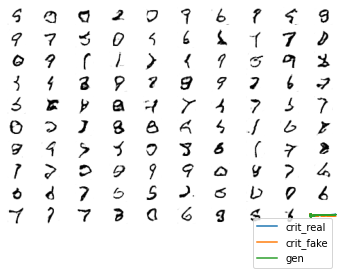

In [13]:
# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)